In [ ]:
#default_exp data.block

In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.data.core import *
from fastai2.data.load import *
from fastai2.data.external import *
from fastai2.data.transforms import *

In [ ]:
from nbdev.showdoc import *

# Data block

> High level API to quickly get your data in a `DataBunch`

## TransformBlock -

In [ ]:
#export
class TransformBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dbunch_kwargs=None):
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  = ToTensor + L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
        self.dl_type,self.dbunch_kwargs = dl_type,({} if dbunch_kwargs is None else dbunch_kwargs)

In [ ]:
#export
def CategoryBlock(vocab=None, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, add_na=add_na))

In [ ]:
#export
def MultiCategoryBlock(encoded=False, vocab=None, add_na=False):
    "`TransformBlock` for multi-label categorical targets"
    tfm = EncodedMultiCategorize(vocab=vocab) if encoded else [MultiCategorize(vocab=vocab, add_na=add_na), OneHotEncode]
    return TransformBlock(type_tfms=tfm)

## General API

In [ ]:
#export
from inspect import isfunction,ismethod

In [ ]:
#export
def _merge_tfms(*tfms):
    "Group the `tfms` in a single list, removing duplicates (from the same class) and instantiating"
    g = groupby(concat(*tfms), lambda o:
        o if isinstance(o, type) else o.__qualname__ if (isfunction(o) or ismethod(o)) else o.__class__)
    return L(v[-1] for k,v in g.items()).map(instantiate)

In [ ]:
#For example, so not exported
from fastai2.vision.core import *
from fastai2.vision.data import *

In [ ]:
#hide
tfms = _merge_tfms([Categorize, MultiCategorize, Categorize(['dog', 'cat'])], Categorize(['a', 'b']))
#If there are several instantiated versions, the last one is kept.
test_eq(len(tfms), 2)
test_eq(tfms[1].__class__, MultiCategorize)
test_eq(tfms[0].__class__, Categorize)
test_eq(tfms[0].vocab, ['a', 'b'])

tfms = _merge_tfms([PILImage.create, PILImage.show])
#Check methods are properly separated
test_eq(len(tfms), 2)
tfms = _merge_tfms([show_image, set_trace])
#Check functions are properly separated
test_eq(len(tfms), 2)

In [ ]:
#export
@docs
@funcs_kwargs
class DataBlock():
    "Generic container to quickly build `DataSource` and `DataBunch`"
    get_x=get_items=splitter=get_y = None
    dl_type = TfmdDL
    _methods = 'get_items splitter get_y get_x'.split()
    def __init__(self, blocks=None, dl_type=None, getters=None, n_inp=None, **kwargs):
        blocks = L(getattr(self,'blocks',(TransformBlock,TransformBlock)) if blocks is None else blocks)
        blocks = L(b() if callable(b) else b for b in blocks)
        self.default_type_tfms = blocks.attrgot('type_tfms', L())
        self.default_item_tfms  = _merge_tfms(*blocks.attrgot('item_tfms',  L()))
        self.default_batch_tfms = _merge_tfms(*blocks.attrgot('batch_tfms', L()))
        for t in blocks: 
            if getattr(t, 'dl_type', None) is not None: self.dl_type = t.dl_type
        if dl_type is not None: self.dl_type = dl_type
        self.databunch = delegates(self.dl_type.__init__)(self.databunch)
        self.dbunch_kwargs = merge(*blocks.attrgot('dbunch_kwargs', {}))
        self.n_inp,self.getters = n_inp,L(getters)
        if getters is not None: assert self.get_x is None and self.get_y is None
        assert not kwargs

    def datasource(self, source, type_tfms=None):
        self.source = source
        items = (self.get_items or noop)(source)
        if isinstance(items,tuple):
            items = L(items).zip()
            labellers = [itemgetter(i) for i in range_of(self.default_type_tfms)]
        else: labellers = [noop] * len(self.default_type_tfms)
        splits = (self.splitter or noop)(items)
        if self.get_x:   labellers[0] = self.get_x
        if self.get_y:   labellers[1] = self.get_y
        if self.getters: labellers = self.getters
        if type_tfms is None: type_tfms = [L() for t in self.default_type_tfms]
        type_tfms = L([self.default_type_tfms, type_tfms, labellers]).map_zip(
            lambda tt,tfm,l: L(l) + _merge_tfms(tt, tfm))
        return DataSource(items, tfms=type_tfms, splits=splits, dl_type=self.dl_type, n_inp=self.n_inp)

    def databunch(self, source, path='.', type_tfms=None, item_tfms=None, batch_tfms=None, **kwargs):
        dsrc = self.datasource(source, type_tfms=type_tfms)
        item_tfms  = _merge_tfms(self.default_item_tfms,  item_tfms)
        batch_tfms = _merge_tfms(self.default_batch_tfms, batch_tfms)
        kwargs = {**self.dbunch_kwargs, **kwargs}
        return dsrc.databunch(path=path, after_item=item_tfms, after_batch=batch_tfms, **kwargs)

    _docs = dict(datasource="Create a `Datasource` from `source` with `type_tfms`",
                 databunch="Create a `DataBunch` from `source` with `item_tfms` and `batch_tfms`")

To build a `DataBlock` you need to give the library four things: the types of your input/labels then at least two functions: `get_items` and `splitter`. You may also need to include `get_x` and `get_y` or a more generic list of `getters` that are applied to the results of `get_items`.

Once those are provided, you automatically get a `DataSource` or a `DataBunch`:

In [ ]:
show_doc(DataBlock.datasource)

<h4 id="DataBlock.datasource" class="doc_header"><code>DataBlock.datasource</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.datasource</code>(**`source`**, **`type_tfms`**=*`None`*)

Create a `Datasource` from `source` with `type_tfms`

In [ ]:
#hide_input
dblock = DataBlock()
show_doc(dblock.databunch, name="DataBlock.databunch")

<h4 id="DataBlock.databunch" class="doc_header"><code>DataBlock.databunch</code><a href="__main__.py#L40" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.databunch</code>(**`source`**, **`path`**=*`'.'`*, **`type_tfms`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`device`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create a [`DataBunch`](/data.core#DataBunch) from `source` with `item_tfms` and `batch_tfms`

You can create a `DataBlock` by passing functions or subclassing. The two following data blocks are the same for instance:

In [ ]:
class MNIST(DataBlock):
    blocks = ImageBlock(cls=PILImageBW),CategoryBlock
    def get_items(self, source): return get_image_files(Path(source))
    def splitter (self, items ): return GrandparentSplitter()(items)
    def get_y    (self, item  ): return parent_label(item)
    
mnist = MNIST()

In [ ]:
mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW),CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  get_y = parent_label)

Each type comes with default transforms that will be applied
- at the base level to create items in a tuple (usually input,target) from the base elements (like filenames)
- at the item level of the datasource
- at the batch level

They are called respectively type transforms, item transforms, batch transforms. In the case of MNIST, the type transforms are the method to create a `PILImageBW` (for the input) and the `Categorize` transform (for the target), the item transform is `ToTensor` and the batch transforms are `Cuda` and `IntToFloatTensor`. You can add any other transforms by passing them in `DataBlock.datasource` or `DataBlock.databunch`.

In [ ]:
test_eq(mnist.default_type_tfms[0], [PILImageBW.create])
test_eq(mnist.default_type_tfms[1].map(type), [Categorize])
test_eq(mnist.default_item_tfms.map(type), [ToTensor])
test_eq(mnist.default_batch_tfms.map(type), [IntToFloatTensor])

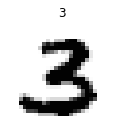

In [ ]:
dsrc = MNIST().datasource(untar_data(URLs.MNIST_TINY))
test_eq(dsrc.vocab, ['3', '7'])
x,y = dsrc.train[0]
test_eq(x.size,(28,28))
show_at(dsrc.train, 0, cmap='Greys', figsize=(2,2));

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 19_callback.mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 20a_distributed.ipynb.
Converted 21_vision.learner.ipynb.
Converted 22_tutorial.imagenette.ipynb.
Converted 23_tutoria